In [29]:
import math
from numpy import genfromtxt
import numpy as np
import NOCgraph

In [30]:
my_data = genfromtxt('traffic_uniform.csv', delimiter=',')
#check the shape of the dataframe
my_data.shape[0] == my_data.shape[-1]
#get mesh
mesh = math.sqrt(my_data.shape[-1])

In [31]:
class core(): 
    def __init__(self):
        self.Id = 0
        self.Traffic = None
        self.Position = None
        self.Neighbours = []

def dist(a , b):
    d = (a[0] -b[0])**2 + (a[1] -b[1])**2 
    d = math.sqrt(d)
    d = math.ceil(d)
    return d

def traffic_allocation(tr): # Map traffic for each core 
    d = {} 
    #print(x, y, tr)
    for i in range(64):
        d[str(i)] = tr[i]
    return d
        
# Base design Construction
def design(traffic):
    Core_design = list()
    for i in range(64):
        Core_design.append(core())
        Core_design[i].Traffic = traffic_allocation(traffic[i])
        Core_design[i].Id = i
        
    random_design = Core_design    
    for i in range(8):
        for j in range(8):
            random_design[i*8+j].Position = [i,j]
    random_design = link(random_design)
    while not check_links(random_design):
        random_design = base_design()
    return random_design

#create regular mesh links, dis = 1
def valid_neighbour_generator(x,y): 
    neighbours = list()
    for i in range(8):
        for j in range(8):
            d = dist([x,y],[i,j]) 
            if  (d==1):
                neighbours.append([i,j])
    return neighbours

def link(design):
    links  = 0
    visited = list()
    i = np.random.choice(range(64))
    while (links < 112):
        if i not in visited:
            visited.append(i)
        else:
            while i in visited:
                i = np.random.choice(range(64))
        if len(visited)> 60:
            visited = []
        links = link_per_core(design,i,links)
    
    return design

def link_per_core(design,position,links):  # links are connected for each core and constrained has been maintained as total links112
    link_count  = 7
    p_x,p_y  =  design[position].Position
    valid_neighs = valid_neighbour_generator(p_x, p_y)
    np.random.shuffle(valid_neighs)
    ind =0
    while True:
        if len(design[position].Neighbours)>= link_count:
            return links
        x,y = valid_neighs[ind]
        c  = core_location(design,[x,y])
        if (len(c.Neighbours)< link_count):
            if ([x,y] not in design[position].Neighbours) and ([p_x,p_y] not in c.Neighbours):
                if links < 112:
                    d= dist([p_x,p_y], [x,y])
                    if d<4:
                        design[position].Neighbours.append([x,y])
                        c.Neighbours.append([p_x,p_y])
                        links+=1
                else:
                    return links 
        if np.random.choice([0,1]):  # randomization added for links.
                return links
        ind = ind+ 1
        if ind >=  len(valid_neighs):
            return links
    
def check_links(design):
    for i in range(64):   
            if len(design[i].Neighbours) == 0:
                return 0
            if len(design[i].Neighbours) > 7:
                return 0
    return 1

def core_location(design , v_pos):
    for i in design:
        if i.Position == v_pos:
            return i
    print("Unknown core")

In [32]:
#function plot NOC graph
import matplotlib.pyplot as plt

def display_NOC(design):
    #plt.figure(figsize=(8,8))
    #plt.xlim(-1,8)
    #plt.ylim(-1,8)
    for i in range(8):
        for j in range(8):
            #plot core placements
            plt.plot(i,j ,'x')
            #plot links
            for k in design[i*8+j].Neighbours:
                plt.plot([k[0],design[i*8+j].Position[0]],[k[1],design[i*8+j].Position[1]],'o-') 
    plt.grid()
    plt.show()

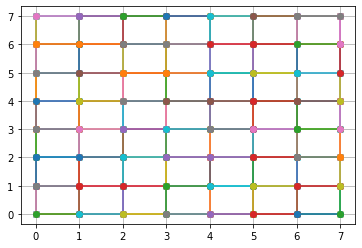

In [33]:
new_design = design(my_data)
display_NOC(new_design)

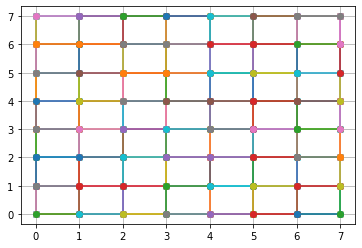

In [34]:
display_NOC(new_design)

In [35]:
#link placement: adjacency matrix & task placement: vector for task placement 
def task_placement(design):
    core_matrix = np.zeros((64))
    for i in range(64):
        core_matrix[design[i].Id] = int(design[i].Position[0]*8+design[i].Position[1])
    core_matrix = core_matrix.reshape(1,64)    
    return core_matrix
       
def link_placement(design):
    core_links = np.zeros((64,64))
    for i in range(64):
         core_links[i] = adjacency(design[i])
    #core_links = core_links.reshape(1,4096)        
    return core_links

def adjacency(c):
    line=np.zeros(64)
    for n in c.Neighbours:
        adj = n[0]*8 +n[1]
        line[adj] = 1
    return line

In [40]:
a = link_placement(new_design)
b = task_placement(new_design)

import pandas
b_adj = pandas.DataFrame(a,columns=b[0], index=b[0])
b_adj

,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,...,54.0,55.0,56.0,57.0,58.0,59.0,60.0,61.0,62.0,63.0
0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
60.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
61.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
62.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0


In [41]:
#dijkstra shortest path algorithm
import queue  

def dijkstra(graph, source, dest):  
    q = queue.PriorityQueue()
    parents = []
    distances = []
    start_weight = float("inf")

    for i in graph.get_vertex():
        weight = start_weight
        if source == i:
            weight = 0
        distances.append(weight)
        parents.append(None)

    q.put(([0, source]))

    while not q.empty():
        v_tuple = q.get()
        v = v_tuple[1]

        for e in graph.get_edge(v):
            candidate_distance = distances[v] + e.weight
            if distances[e.vertex] > candidate_distance:
                distances[e.vertex] = candidate_distance
                parents[e.vertex] = v
                # primitive but effective negative cycle detection
                if candidate_distance < -1000:
                    raise Exception("Negative cycle detected")
                q.put(([distances[e.vertex], e.vertex]))

    shortest_path = []
    end = dest
    while end is not None:
        shortest_path.append(end)
        end = parents[end]

    shortest_path.reverse()
    if len(shortest_path)-1 == 0:
        return 'invalid'
    return len(shortest_path)-1
   

In [42]:
def cost_per_core(design,graph,s):
    hop_count=0
    traffic_wtd_count = 0
    for de in range(64):
        src_id = design[s].Id
        d_id =  design[de].Id
        if s != de:
            hop_count = dijkstra(graph,src_id,d_id)
            if hop_count == 'invalid':
                return 'invalid'
            else:
                traffic = design[s].Traffic[str(d_id)]
                traffic_wtd_count += (hop_count * traffic)
    return traffic_wtd_count

def get_cost(design,wtd_graph):
    cost = 0
    for cores in range(64):
        weight = cost_per_core(design,wtd_graph,cores)
        if weight == 'invalid':
            print('Not a valid design')
            return 'invalid'
        else:
            cost+= weight
    return cost

In [43]:
new_graph = NOCgraph.create_graph(new_design)

In [44]:
get_cost(new_design,new_graph)

8596.112898349664

In [15]:
#load file traffic_random
traffic_rand = genfromtxt('traffic_rand.csv', delimiter=',')

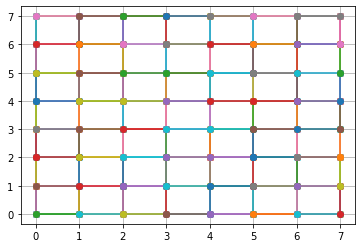

In [16]:
design_rand = design(traffic_rand)
display_NOC(design_rand)

In [17]:
graph_rand = NOCgraph.create_graph(design_rand)
get_cost(design_rand,graph_rand)

10855.716749642652

In [18]:
#load file traffic_complement
traffic_comp = genfromtxt('traffic_complement.csv', delimiter=',')

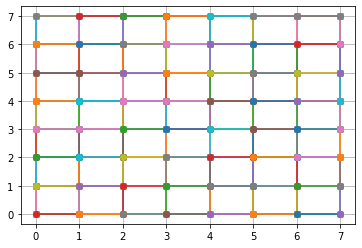

In [19]:
design_comp = design(traffic_comp)
display_NOC(design_comp)

In [20]:
graph_comp = NOCgraph.create_graph(design_comp)
get_cost(design_comp,graph_comp)

2513.2339481947247